In [1]:
#Import packages
import pmdarima as pm
import sklearn
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
import time
import os
import numpy as np
import pandas as pd
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split 
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Loading Data
data = pd.read_csv("allvariables.csv",index_col=0)
X = data.drop(["TSLA","Net_Transaction","Abs_Transaction"],axis=1)
Y = data["TSLA"] ## Dropping the first row with NA values

## Linear Regression Model

In [3]:
## Time Series Split for Linear Regression

train_size = int(len(Y)*0.8)
training_x, testing_x = X.iloc[:train_size,:], X.iloc[train_size:,:]
training_y, testing_y = Y[0:train_size], Y[train_size:]

In [4]:
## Training LinReg Model
from sklearn.linear_model import LinearRegression
lm = LinearRegression()

lm.fit(training_x, training_y)

LinearRegression()

In [5]:
rmse_training = np.sqrt(mean_squared_error(lm.predict(training_x), training_y))
rmse_testing = np.sqrt(mean_squared_error(lm.predict(testing_x), testing_y))
print('Linear Regression Train RMSE = %.3f' % (rmse_training))
print('Linear Regression Test RMSE = %.3f' % (rmse_testing))

Linear Regression Train RMSE = 55.457
Linear Regression Test RMSE = 109.242


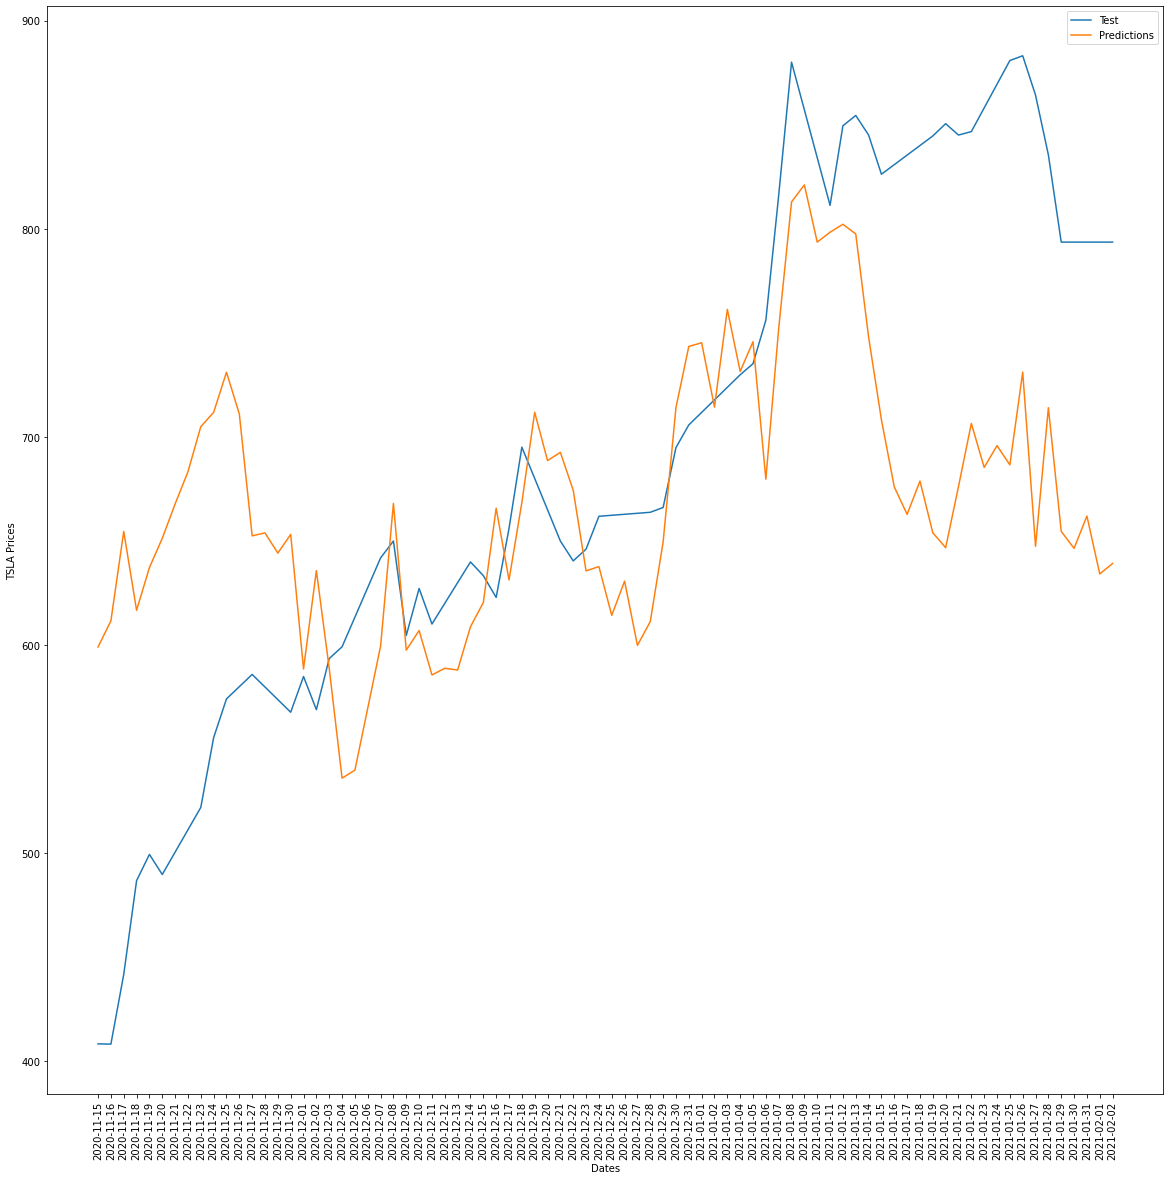

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,20))
plt.plot(testing_y,label = "Test")
plt.xlabel("Dates")
plt.ylabel("TSLA Prices")
plt.plot(lm.predict(testing_x), label = "Predictions")
plt.legend()
plt.xticks(rotation = 90)
plt.show()
fig.savefig("LinReg Graph.png")

## ARIMA/ARIMAX Modelling (Please Read!)

ARIMA order = (p,d,q)<br>
p = "Auto-Regressive" term (number of lags of Y to be used as predictors)<br>
d = "Integrated" Term (Number of Differencing of Y so that we can get a stationary time series (Stationary time series makes the time series more constant so that we can predict better)<br>
q = "Moving Average" Term (number of lagged forecast errors that should go into the ARIMA Model)<br>

In [10]:
# evaluate an ARIMAX model for a given order (p,d,q)
def evaluate_arima_model(yvar, arima_order,xvar=0): # xvar = None if Pure ARIMA Model
# prepare training dataset
    train_size = int(len(yvar)*0.8)
    train_x = test_x = None
    if isinstance(xvar,pd.DataFrame) or isinstance(xvar,pd.Series):
        train_x, test_x = xvar.iloc[:train_size,:], xvar.iloc[train_size:,:]
    train_y, test_y = yvar[0:train_size], yvar[train_size:]
    history = [x for x in train_y]
    # make predictions
    predictions = list()
    for t in range(len(test_y)):
        if isinstance(xvar,pd.DataFrame) or isinstance(xvar,pd.Series):
            model = ARIMA(history, order=arima_order,exog=train_x)
            model_fit = model.fit()
            output = model_fit.forecast(exog=test_x.iloc[t:t+1,:])
            yhat = output[0]
            predictions.append(yhat)
            obs = test_y[t]
            add_X = test_x.iloc[t,:]
            history.append(obs)
            train_x = train_x.append(add_X)
        else:
            model = ARIMA(history, order=arima_order)
            model_fit = model.fit()
            output = model_fit.forecast()
            yhat = output[0]
            predictions.append(yhat)
            obs = test_y[t]
            history.append(obs)
    rmse = np.sqrt(mean_squared_error(list(test_y), predictions))
    return rmse        
  
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(xvar, dataset, p_values, d_values, q_values):
    #dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order, xvar)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [167]:
## Grid Search for ARIMA Parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
evaluate_models(0,Y, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=418.355
ARIMA(0, 0, 1) RMSE=211.644
ARIMA(0, 0, 2) RMSE=132.028
ARIMA(0, 1, 0) RMSE=19.528
ARIMA(0, 1, 1) RMSE=18.880
ARIMA(0, 1, 2) RMSE=18.941
ARIMA(0, 2, 0) RMSE=23.047
ARIMA(0, 2, 1) RMSE=19.452
ARIMA(0, 2, 2) RMSE=18.816
ARIMA(1, 0, 0) RMSE=19.615
ARIMA(1, 0, 1) RMSE=18.971
ARIMA(1, 0, 2) RMSE=19.024
ARIMA(1, 1, 0) RMSE=18.924
ARIMA(1, 1, 1) RMSE=19.040
ARIMA(1, 1, 2) RMSE=18.973
ARIMA(1, 2, 0) RMSE=22.457
ARIMA(1, 2, 1) RMSE=18.859
ARIMA(1, 2, 2) RMSE=19.389
ARIMA(2, 0, 0) RMSE=19.009
ARIMA(2, 0, 1) RMSE=19.577
ARIMA(2, 0, 2) RMSE=18.941
ARIMA(2, 1, 0) RMSE=19.008
ARIMA(2, 1, 1) RMSE=18.984
ARIMA(2, 1, 2) RMSE=18.879
ARIMA(2, 2, 0) RMSE=22.364
ARIMA(2, 2, 1) RMSE=18.920
ARIMA(2, 2, 2) RMSE=18.805
ARIMA(4, 0, 1) RMSE=19.166
ARIMA(4, 0, 2) RMSE=19.176
ARIMA(4, 1, 0) RMSE=18.986
ARIMA(4, 1, 1) RMSE=18.954
ARIMA(4, 1, 2) RMSE=18571153.958
ARIMA(4, 2, 0) RMSE=20.299
ARIMA(4, 2, 1) RMSE=18.867
ARIMA(4, 2, 2) RMSE=18.954
ARIMA(6, 0, 0) RMSE=25.404
ARIMA(6, 0, 1) RMSE

In [11]:
# Generate the Graph for the train and predictions
yvar = Y
train_size = int(len(yvar)*0.8)
train_y, test_y = yvar[0:train_size], yvar[train_size:]
history = [x for x in train_y]
# make predictions
predictions = list()
for t in range(len(test_y)):
    model = ARIMA(history, order=(6,2,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_y[t]
    history.append(obs)
#rmse = np.sqrt(mean_squared_error(list(test_y), predictions))

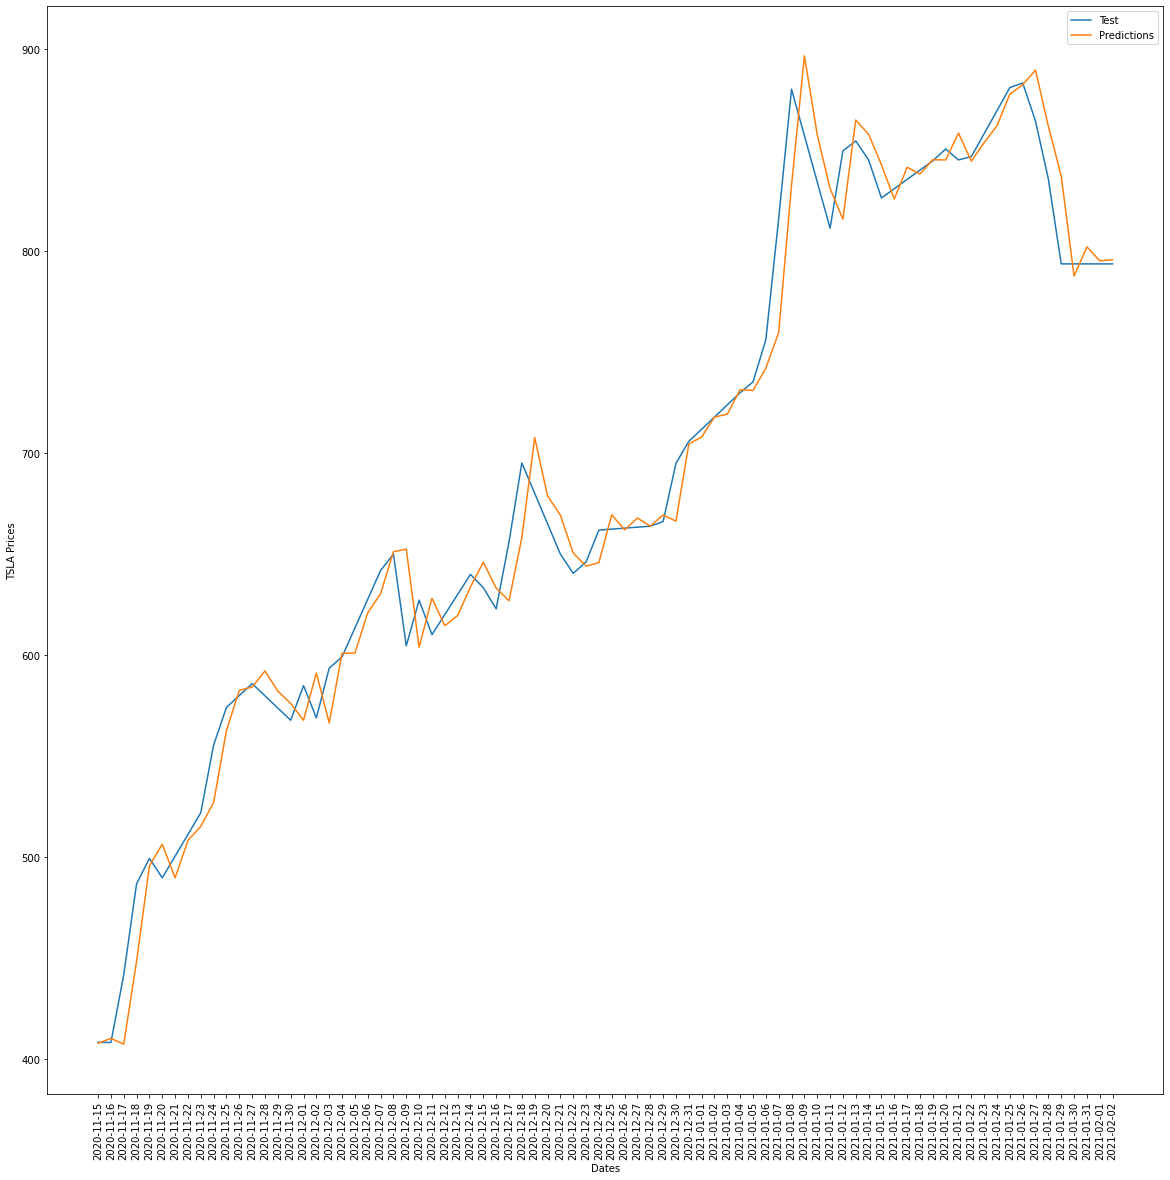

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plt.plot(test_y,label = "Test")
plt.xlabel("Dates")
plt.ylabel("TSLA Prices")
plt.plot(predictions, label = "Predictions")
plt.legend()
plt.xticks(rotation = 90)
plt.show()

In [39]:
# Finding RMSE for model with ALL the exogenous variables
# Using the Optimal ARIMA Order found above (ARIMA(6,2,2))
evaluate_arima_model(Y,(6,2,2),xvar=X)

20.674678316913692

## From this section onwards, I will be using the interaction Variables Data

In [13]:
# Loading Data with square-transformed data + interaction
new_path = "full_transform_0.7.csv"
X = pd.read_csv(new_path,index_col=0) # Loading Transformed & Interation Variables
X.index = data.index # Set DateTimeIndex for X # Variables are in order of decreasing significance
print(X.head(5))
print(X.shape)

            Close_NIO_sqrt  Close_NIO  Close_NIO_square  Close_Toyota_square  \
Date                                                                           
2020-01-02        1.928730       3.72           13.8384         20232.219022   
2020-01-03        1.957039       3.83           14.6689         19810.562500   
2020-01-04        1.944222       3.78           14.2884         19812.439586   
2020-01-05        1.931321       3.73           13.9129         19814.316762   
2020-01-06        1.918333       3.68           13.5424         19816.194026   

            Close_Toyota  Close_Toyota_sqrt  Close_Ford  Close_Honda_square  \
Date                                                                          
2020-01-02    142.240005          11.926441    9.420000          820.249543   
2020-01-03    140.750000          11.863811    9.210000          791.296844   
2020-01-04    140.756668          11.864092    9.193333          789.797288   
2020-01-05    140.763336          11.864373 

In [161]:
# ARIMAX with transformed variables (Stepwise addition of decreasingly significant variables into the pool)
rmse_scores = []
for w in range(1,X.shape[1]+1):
    train_size = int(len(Y)*0.8)
    train_x, test_x = X.iloc[:train_size,:w], X.iloc[train_size:,:w]
    train_y, test_y = Y[0:train_size], Y[train_size:]
    history = [x for x in train_y]
    predictions = list()
    for t in range(len(test_y)):
        model = ARIMA(history, order=(6,2,2),exog = train_x)
        model_fit = model.fit()
        output = model_fit.forecast(steps = 1, exog=test_x.iloc[t:t+1,:])
        yhat = output[0]
        predictions.append(yhat)
        obs = test_y[t]
        add_X = test_x.iloc[t,:]
        history.append(obs)
        train_x = train_x.append(add_X)
    print("Variables: %s" % list(train_x.columns))
    print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(list(test_y),predictions)))

Variables: ['Close_NIO_sqrt']
Test RMSE: 18.495
Variables: ['Close_NIO_sqrt', 'Close_NIO']
Test RMSE: 18.728
Variables: ['Close_NIO_sqrt', 'Close_NIO', 'Close_NIO_square']
Test RMSE: 19.121
Variables: ['Close_NIO_sqrt', 'Close_NIO', 'Close_NIO_square', 'Close_Toyota_square']
Test RMSE: 19.177
Variables: ['Close_NIO_sqrt', 'Close_NIO', 'Close_NIO_square', 'Close_Toyota_square', 'Close_Toyota']
Test RMSE: 19.753
Variables: ['Close_NIO_sqrt', 'Close_NIO', 'Close_NIO_square', 'Close_Toyota_square', 'Close_Toyota', 'Close_Toyota_sqrt']
Test RMSE: 19.611
Variables: ['Close_NIO_sqrt', 'Close_NIO', 'Close_NIO_square', 'Close_Toyota_square', 'Close_Toyota', 'Close_Toyota_sqrt', 'Close_Ford']
Test RMSE: 19.333
Variables: ['Close_NIO_sqrt', 'Close_NIO', 'Close_NIO_square', 'Close_Toyota_square', 'Close_Toyota', 'Close_Toyota_sqrt', 'Close_Ford', 'Close_Honda_square']
Test RMSE: 19.341
Variables: ['Close_NIO_sqrt', 'Close_NIO', 'Close_NIO_square', 'Close_Toyota_square', 'Close_Toyota', 'Close_Toyo

In [157]:
## Grid Search for ARIMAX Parameters (Only Variable = NIO_SQRT)
p_values = [0, 1, 2, 4, 6]
d_values = range(0, 3)
q_values = range(0, 3)
final_X = X.iloc[:,0] # Take NIO_SQRT only
evaluate_models(pd.DataFrame(final_X),Y, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=109.728
ARIMA(0, 0, 1) RMSE=59.964
ARIMA(0, 0, 2) RMSE=41.191
ARIMA(0, 1, 0) RMSE=19.023
ARIMA(0, 1, 1) RMSE=18.526
ARIMA(0, 1, 2) RMSE=18.620
ARIMA(0, 2, 0) RMSE=23.194
ARIMA(0, 2, 1) RMSE=19.166
ARIMA(0, 2, 2) RMSE=18.526
ARIMA(1, 0, 0) RMSE=19.144
ARIMA(1, 0, 1) RMSE=18.639
ARIMA(1, 0, 2) RMSE=18.712
ARIMA(1, 1, 0) RMSE=18.600
ARIMA(1, 1, 1) RMSE=18.650
ARIMA(1, 1, 2) RMSE=18.667
ARIMA(1, 2, 0) RMSE=22.436
ARIMA(1, 2, 1) RMSE=18.588
ARIMA(1, 2, 2) RMSE=18.985
ARIMA(2, 0, 0) RMSE=18.729
ARIMA(2, 0, 1) RMSE=18.867
ARIMA(2, 0, 2) RMSE=4127.506
ARIMA(2, 1, 0) RMSE=18.606
ARIMA(2, 1, 1) RMSE=18.666
ARIMA(2, 1, 2) RMSE=18.486
ARIMA(2, 2, 0) RMSE=22.192
ARIMA(2, 2, 1) RMSE=18.575
ARIMA(2, 2, 2) RMSE=18.511
ARIMA(4, 0, 0) RMSE=18.659
ARIMA(4, 0, 1) RMSE=18.653
ARIMA(4, 0, 2) RMSE=18.500
ARIMA(4, 1, 0) RMSE=18.613
ARIMA(4, 1, 1) RMSE=18.591
ARIMA(4, 1, 2) RMSE=18.603
ARIMA(4, 2, 0) RMSE=20.315
ARIMA(4, 2, 1) RMSE=18.569
ARIMA(4, 2, 2) RMSE=18.423
ARIMA(6, 0, 0) RMSE=18.76

In [14]:
## Run Final Optimal ARIMAX Model to make test v predictions chart
final_X = list(X.iloc[:,0]) # Take NIO_SQRT only
yvar = Y
train_size = int(len(yvar)*0.8)
train_x1, test_x1 = final_X[0:train_size], final_X[train_size:]
train_y1, test_y1 = yvar[0:train_size], yvar[train_size:]
history = [x for x in train_y1]
# make predictions
predictions = list()
for t in range(len(test_y1)):
    model = ARIMA(history, order=(4,2,2),exog=train_x1)
    model_fit = model.fit()
    output = model_fit.forecast(exog=test_x1[t:t+1])
    yhat = output[0]
    predictions.append(yhat)
    obs = test_y1[t]
    add_X = test_x1[t]
    history.append(obs)
    train_x1.append(add_X)

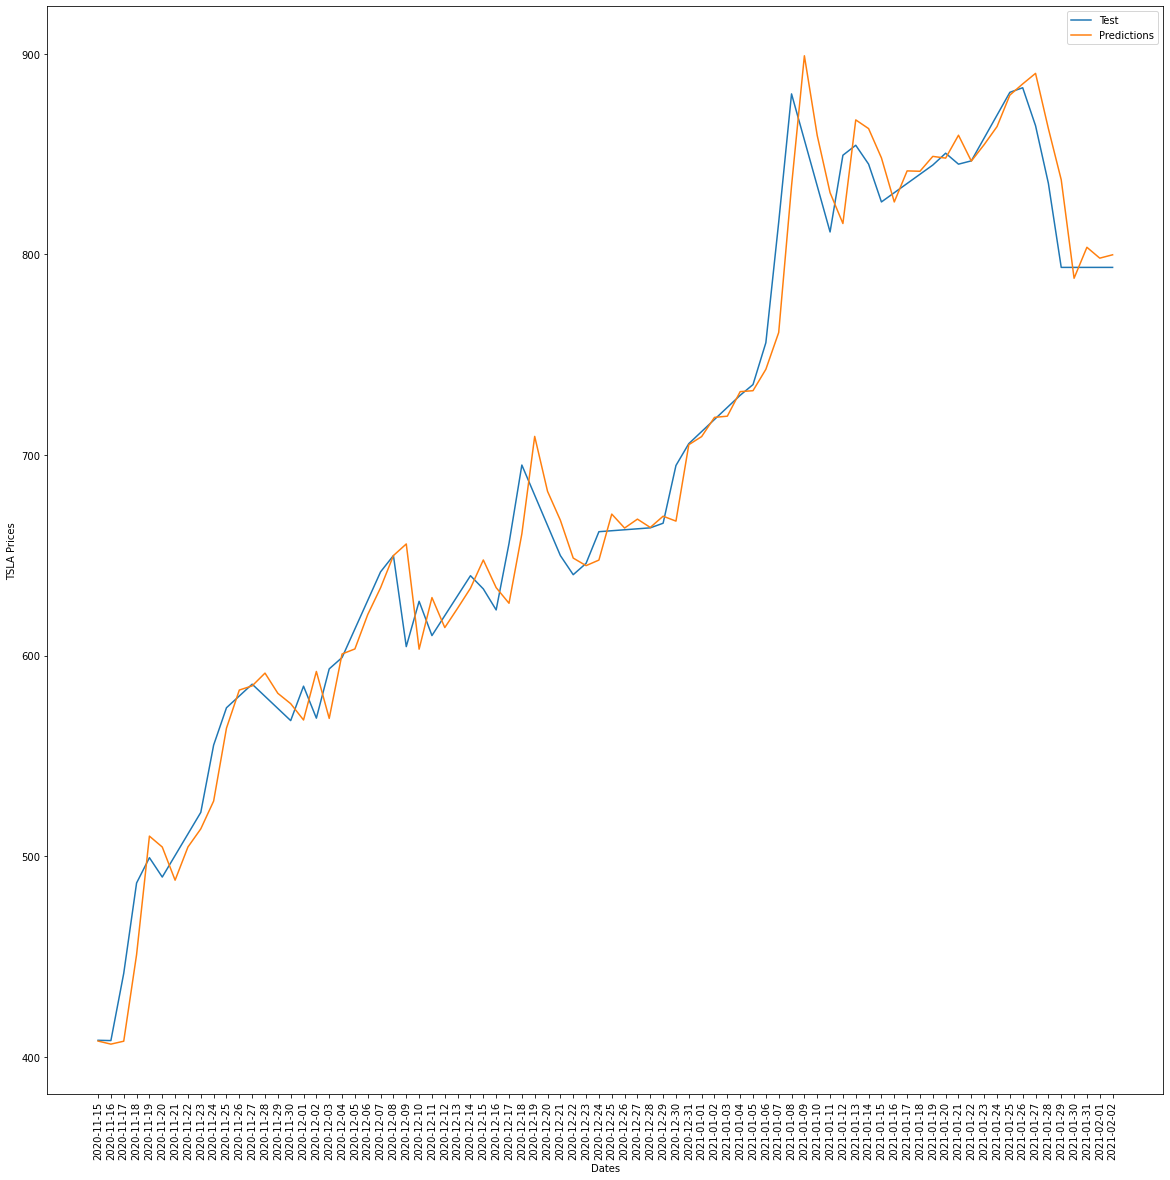

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plt.plot(test_y1,label = "Test")
plt.xlabel("Dates")
plt.ylabel("TSLA Prices")
plt.plot(predictions, label = "Predictions")
plt.legend()
plt.xticks(rotation=90)
plt.show()